In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
from util import show, plot_images, plot_tensors

In [4]:
from torchvision import transforms
from torch.utils.data import Dataset
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
from torchvision import transforms
from skimage.measure import compare_psnr

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

TRAIN_DATA_PATH = "./Confocal_BPAE_B/raw"
GT_DATA_PATH = "./Confocal_BPAE_B/gt"
TRANSFORM_IMG = transforms.Compose([
    transforms.CenterCrop(256),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()

])
train_data = torchvision.datasets.ImageFolder(
    root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
gt_data = torchvision.datasets.ImageFolder(
    root=GT_DATA_PATH, transform=TRANSFORM_IMG)

dataset1 = train_data
dataset2 = gt_data

In [5]:
class gtmatch():
    def __init__(self, dataset1, dataset2, batch_size):
        self.dataset1 = dataset1
        self.dataset2 = dataset2

    def __getitem__(self, index):
        x = self.dataset1[index][0]
        y = self.dataset2[int(index / batch_size % batch_size)][0]
        return x, y

    def __len__(self):
        return len(self.dataset1)


newdataset = gtmatch(dataset1, dataset2, 50)

In [6]:
from torch import randn
batch_size = 50


def add_noise(img):
    poisson=torch.distributions.poisson.Poisson(img.detach())
    noise=poisson.sample()
    return img.detach()+noise*.5

class SyntheticNoiseDataset(Dataset):
    def __init__(self, data, mode='train'):
        self.mode = mode
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index][0]
        gt = self.data[index][1]

        return add_noise(img), img, gt

In [7]:
newdataset = SyntheticNoiseDataset(newdataset, 'train')

In [8]:
from models.RIM_v2 import RIM

In [9]:
model = RIM()

In [12]:
from torch.nn import MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader
import logging
loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [10]:
from torch.utils.data.sampler import SequentialSampler
validation_split = .2
random_seed = 42
shuffle_dataset = False

# Creating data indices for training and validation splits:
dataset_size = len(newdataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

train_indices, val_indices = indices[split:], indices[:split]

if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

# Creating PT data samplers and loaders:
train_sampler = SequentialSampler(train_indices)
valid_sampler = SequentialSampler(val_indices)


train_loader = torch.utils.data.DataLoader(
    newdataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(newdataset, batch_size=batch_size,
                                                sampler=valid_sampler)

## RIM

In [12]:
data_loader = train_loader

losses = []
val_losses = []
clean_image_corr = []
best_images = []
noisy_input = []
best_val_loss = 1
st1=0
st2=-0

for j in range(0,5):
    
    print(j)

    for i, batch in enumerate(data_loader):

        noisy_images, clean_images, gt = batch

        model.train()

        net_input = noisy_images

        net_output, st1, st2 = model(net_input, st1, st2, i, j)
        
        st1=st1.detach()
        st2=st2.detach()

        loss = loss_function(net_output+noisy_images, clean_images)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        losses.append(loss.item())

        model.eval()

        val_loss = loss_function(net_output, noisy_images)

        val_losses.append(val_loss.item())
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            denoised = noisy_images+model(noisy_images, st1, st2, i, j)[0].detach()
            net_input_np = noisy_images.cpu().numpy()[0, 0].astype(np.float64)
            denoised_arr = np.clip(denoised, 0, 1).cpu().numpy()[
                0, 0].astype(np.float64)
            clean_comp = clean_images.detach().cpu().numpy()[
                0, 0].astype(np.float64)
            best_psnr = compare_psnr(clean_comp, denoised_arr)
            noisy_input.append(net_input_np)
            best_images.append(denoised_arr)
            clean_image_corr.append(clean_images)
            print("Loss (", j,"-",i, "): \t", round(loss.item(), 4))
            print("\tModel PSNR: ", np.round(best_psnr, 2))


0


/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


Loss ( 0 - 0 ): 	 0.1375
	Model PSNR:  8.75
1
Loss ( 1 - 13 ): 	 0.1603
	Model PSNR:  8.36
Loss ( 1 - 15 ): 	 0.1533
	Model PSNR:  8.56
2
Loss ( 2 - 0 ): 	 0.133
	Model PSNR:  8.87
Loss ( 2 - 3 ): 	 0.1295
	Model PSNR:  9.09
Loss ( 2 - 4 ): 	 0.1391
	Model PSNR:  8.95
Loss ( 2 - 7 ): 	 0.1349
	Model PSNR:  9.16
Loss ( 2 - 9 ): 	 0.116
	Model PSNR:  9.45
Loss ( 2 - 11 ): 	 0.1188
	Model PSNR:  9.56
Loss ( 2 - 12 ): 	 0.122
	Model PSNR:  9.53
Loss ( 2 - 13 ): 	 0.1269
	Model PSNR:  9.39
Loss ( 2 - 15 ): 	 0.1211
	Model PSNR:  9.63
3
Loss ( 3 - 0 ): 	 0.103
	Model PSNR:  9.99
Loss ( 3 - 3 ): 	 0.1008
	Model PSNR:  10.18
Loss ( 3 - 7 ): 	 0.1079
	Model PSNR:  10.14
Loss ( 3 - 8 ): 	 0.097
	Model PSNR:  10.49
Loss ( 3 - 9 ): 	 0.0909
	Model PSNR:  10.49
4
Loss ( 4 - 0 ): 	 0.0813
	Model PSNR:  11.04
Loss ( 4 - 3 ): 	 0.0802
	Model PSNR:  11.18
Loss ( 4 - 9 ): 	 0.0726
	Model PSNR:  11.41


In [14]:
model_output = []
Input_PSNR = []
Model_PSNR = []

model_output = []
Input_PSNR = []
Model_PSNR = []
Model_loss = []
clipped_model_loss = []
j=1


for i, batch in enumerate(validation_loader):

    noisy_images, clean_images, gt = batch

    model.eval()

    net_input = noisy_images

    denoised = noisy_images+model(noisy_images, st1, st2, i, j)[0].detach()
    denoised_arr = np.clip(denoised, 0, 1).cpu().numpy()[
        0, 0].astype(np.float64)

    net_input_np = noisy_images.cpu().numpy()[0, 0].astype(np.float64)
    clean_comp = clean_images.detach().cpu().numpy()[
        0, 0].astype(np.float64)
    Input_PSNR.append(compare_psnr(clean_comp, net_input_np))
    Model_PSNR.append(compare_psnr(clean_comp, denoised_arr))
    model_output.append([torch.from_numpy(clean_comp),torch.from_numpy(net_input_np), torch.from_numpy(
        denoised_arr), gt])
    Input_PSNR.append(compare_psnr(clean_comp, net_input_np))
    Model_PSNR.append(compare_psnr(clean_comp, denoised_arr))

    Model_loss.append(loss_function(denoised, clean_images))
    clipped_model_loss.append(loss_function(
        torch.from_numpy(denoised_arr), clean_images))

/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/w

Input PSNR =  21.08
Simple RIM PSNR =  11.9191

Simple RIM Loss =  tensor(0.0748)
Clipped Simple RIM Loss =  tensor(0.0696, dtype=torch.float64)


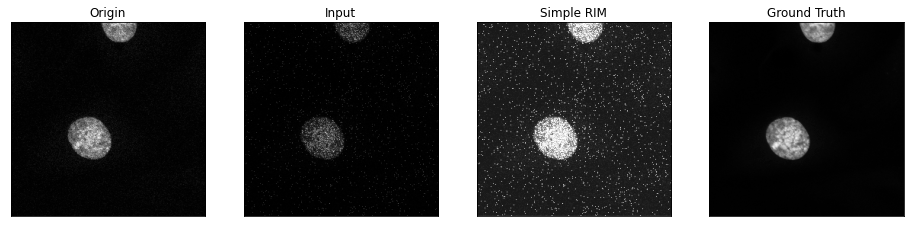

In [15]:
idx=1
plot_tensors(model_output[idx], ["Origin","Input", "Simple RIM","Ground Truth"])
print("Input PSNR = ", np.round(Input_PSNR[idx], 2))
print("Simple RIM PSNR = ", np.round(Model_PSNR[idx], 4))
print("")
print("Simple RIM Loss = ", np.round(Model_loss[idx], 4))
print("Clipped Simple RIM Loss = ", np.round(clipped_model_loss[idx], 4))

In [16]:
print("Average Input PSNR = ", np.round(np.mean(Input_PSNR), 2))
print("Average Simple RIM PSNR = ", np.round(np.mean(Model_PSNR), 4))
print("")
print("Average Simple RIM Loss = ", np.round(np.mean(Model_loss), 4))
print("Average Clipped Simple RIM Loss = ", np.round(np.mean(clipped_model_loss), 4))

Average Input PSNR =  19.73
Average Simple RIM PSNR =  11.7871

Average Simple RIM Loss =  0.0708
Average Clipped Simple RIM Loss =  0.0679


## RIM with J-Invariant Mask

In [13]:
from mask_RIM_v2 import Masker
masker = Masker(width=4, mode='interpolate')

data_loader = train_loader

losses = []
val_losses = []
clean_image_corr = []
best_images = []
noisy_input = []
best_Jimages = []
best_val_loss = 1
st1=0
st2=0

for j in range(0,5):
    
    print(j)

    for i, batch in enumerate(data_loader):
        noisy_images, clean_images, gt = batch

        model.train()

        net_input, mask = masker.mask(noisy_images, i % (masker.n_masks - 1))


        net_output, st1, st2 = model(net_input, st1, st2, i, j)
        
        st1=st1.detach()
        st2=st2.detach()

        loss = loss_function(net_output*mask, noisy_images*mask)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        losses.append(loss.item())

        model.eval()
        val_loss = loss_function(net_output*mask, noisy_images*mask)
        val_losses.append(val_loss.item())

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            denoised = noisy_images+model(noisy_images, st1, st2, i, j)[0].detach()
            Jinv = noisy_images + \
                masker.infer_full_image(noisy_images, model, st1, st2, i, j)[0].detach()
            Jinv = np.clip(Jinv, 0, 1).cpu().numpy()[
                0, 0].astype(np.float64)
            net_input_np = noisy_images.cpu().numpy()[0, 0].astype(np.float64)
            denoised_arr = np.clip(denoised, 0, 1).cpu().numpy()[
                0, 0].astype(np.float64)
            clean_comp = clean_images.detach().cpu().numpy()[
                0, 0].astype(np.float64)

            best_psnr = compare_psnr(clean_comp, Jinv)

            noisy_input.append(net_input_np)
            best_images.append(denoised_arr)
            best_Jimages.append(Jinv)
            clean_image_corr.append(clean_images)
            print("Loss (", j,"-",i, "): \t", round(loss.item(), 4))
            print("\tModel PSNR: ", np.round(best_psnr, 2))

0


/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


Loss ( 0 - 0 ): 	 0.0082
	Model PSNR:  25.05
Loss ( 0 - 3 ): 	 0.0081
	Model PSNR:  23.58
Loss ( 0 - 8 ): 	 0.008
	Model PSNR:  22.85
Loss ( 0 - 9 ): 	 0.0067
	Model PSNR:  23.28
1
Loss ( 1 - 0 ): 	 0.0054
	Model PSNR:  24.09
Loss ( 1 - 3 ): 	 0.0052
	Model PSNR:  23.11
Loss ( 1 - 8 ): 	 0.005
	Model PSNR:  22.42
Loss ( 1 - 9 ): 	 0.0039
	Model PSNR:  22.61
2
Loss ( 2 - 0 ): 	 0.0026
	Model PSNR:  22.93
Loss ( 2 - 3 ): 	 0.0024
	Model PSNR:  22.2
Loss ( 2 - 8 ): 	 0.0023
	Model PSNR:  21.23
Loss ( 2 - 9 ): 	 0.0014
	Model PSNR:  21.14
3
Loss ( 3 - 0 ): 	 0.0009
	Model PSNR:  21.53
Loss ( 3 - 9 ): 	 0.0007
	Model PSNR:  20.2
4
Loss ( 4 - 0 ): 	 0.0007
	Model PSNR:  19.54


In [14]:
model_output = []
Input_PSNR = []
Model_PSNR = []
JInv_PSNR = []
Model_loss = []
clipped_model_loss = []

JInv_loss = []
clipped_JInv_loss = []

for i, batch in enumerate(validation_loader):

    noisy_images, clean_images, gt = batch

    model.eval()

    net_input = noisy_images

    denoised = noisy_images+model(noisy_images, st1, st2, i, j)[0].detach()
    denoised_arr = np.clip(denoised, 0, 1).cpu().numpy()[
        0, 0].astype(np.float64)
    Jinv = noisy_images + \
        masker.infer_full_image(noisy_images, model, st1, st2, i, j)[0].detach()
    Jinv_np = np.clip(Jinv, 0, 1).cpu().numpy()[
        0, 0].astype(np.float64)

    net_input_np = noisy_images.cpu().numpy()[0, 0].astype(np.float64)
    clean_comp = clean_images.detach().cpu().numpy()[
        0, 0].astype(np.float64)

    model_output.append([torch.from_numpy(clean_comp),torch.from_numpy(net_input_np), torch.from_numpy(
        denoised_arr), torch.from_numpy(Jinv_np), gt])
    Input_PSNR.append(compare_psnr(clean_comp, net_input_np))
    Model_PSNR.append(compare_psnr(clean_comp, denoised_arr))
    JInv_PSNR.append(compare_psnr(clean_comp, Jinv_np))
    
    Model_loss.append(loss_function(denoised, noisy_images))
    clipped_model_loss.append(loss_function(
        torch.from_numpy(denoised_arr), noisy_images))
    
    JInv_loss.append(loss_function(Jinv, noisy_images))
    clipped_JInv_loss.append(loss_function(
        torch.from_numpy(Jinv_np), noisy_images))

/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([50, 1, 256, 256])) that is different to the input size (torch.Size([256, 256])). This will likel

Input PSNR =  18.74
Simple RIM PSNR =  17.3646
J-Invariant RIM PSNR =  17.3644

Simple RIM Loss =  tensor(0.0059)
Clipped Simple RIM Loss =  tensor(0.0264, dtype=torch.float64)

J-Invariant RIM Loss =  tensor(0.0059)
Clipped J-Invariant RIM Loss =  tensor(0.0264, dtype=torch.float64)


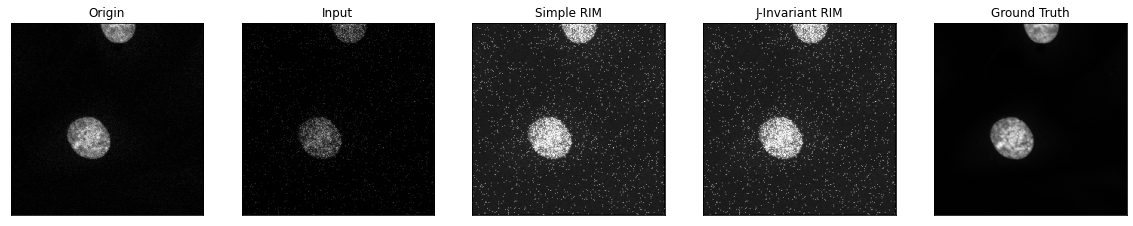

In [15]:
idx=1
plot_tensors(model_output[idx], ["Origin","Input", "Simple RIM",
                               "J-Invariant RIM", "Ground Truth"])
print("Input PSNR = ", np.round(Input_PSNR[idx], 2))
print("Simple RIM PSNR = ", np.round(Model_PSNR[idx], 4))
print("J-Invariant RIM PSNR = ", np.round(JInv_PSNR[idx], 4))
print("")
print("Simple RIM Loss = ", np.round(Model_loss[idx], 4))
print("Clipped Simple RIM Loss = ", np.round(clipped_model_loss[idx], 4))
print("")
print("J-Invariant RIM Loss = ", np.round(JInv_loss[idx], 4))
print("Clipped J-Invariant RIM Loss = ", np.round(clipped_JInv_loss[idx], 4))

In [16]:
print("Average Input PSNR = ", np.round(np.mean(Input_PSNR), 2))
print("Average Simple RIM PSNR = ", np.round(np.mean(Model_PSNR), 4))
print("Average J-Invariant RIM PSNR = ", np.round(np.mean(JInv_PSNR), 4))
print("")
print("Average Simple RIM Loss = ", np.round(np.mean(Model_loss), 4))
print("Average Clipped Simple RIM Loss = ", np.round(np.mean(clipped_model_loss), 4))
print("")
print("Average J-Invariant RIM Loss = ", np.round(np.mean(JInv_loss), 4))
print("Average Clipped J-Invariant RIM Loss = ", np.round(np.mean(clipped_JInv_loss), 4))

Average Input PSNR =  19.84
Average Simple RIM PSNR =  17.7521
Average J-Invariant RIM PSNR =  17.752

Average Simple RIM Loss =  0.0059
Average Clipped Simple RIM Loss =  0.0236

Average J-Invariant RIM Loss =  0.0059
Average Clipped J-Invariant RIM Loss =  0.0236
